In [1]:
!pip install kagglehub[pandas-datasets]

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")

In [3]:
print(path)

/home/cpsc452_yc2243/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2


In [4]:
!nvidia-smi

Sat May  3 08:05:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               On  |   00000000:17:00.0 Off |                  Off |
| 30%   23C    P8             15W /  230W |       2MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import numpy as np
import cv2
import pandas as pd
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import itertools
import torch.optim as optim
import torch.nn.functional as F
import math

from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# read and process files

In [6]:
# df_projections = pd.read_csv('/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/indiana_projections.csv')
df_projections = pd.read_csv(f'{path}/indiana_projections.csv')
df_reports = pd.read_csv('./indiana_reports_labeled.csv')

In [7]:
df_reports.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression,extracted_labels,Cardiomegaly,...,Thickening,Hernia,Pulmonary Edema,Pneumonia,Consolidation,Pneumothorax,Fibrosis,Mass,Granuloma,Normal
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,NaN,0,...,0,0,0,0,0,0,0,0,0,1
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,Cardiomegaly,1,...,0,0,0,0,0,0,0,0,0,0
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",NaN,0,...,0,0,0,0,0,0,0,0,0,1
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,"Fibrosis, Emphysema",0,...,0,0,0,0,0,0,1,0,0,0
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,Thickening,0,...,1,0,0,0,0,0,0,0,0,0


merge report table and projection table

In [8]:
# all label columns (15 diseases + Normal)
label_columns = [
    "Cardiomegaly", "Pulmonary Atelectasis", "Pleural Effusion", "Nodule",
    "Infiltrate", "Emphysema", "Thickening", "Hernia", "Pulmonary Edema",
    "Pneumonia", "Consolidation", "Pneumothorax", "Fibrosis", "Mass",
    "Granuloma", "Normal"
]

# rows that have at least one label equal to 1
df_reports = df_reports[df_reports[label_columns].sum(axis=1) > 0]

merged_df = pd.merge(df_projections, df_reports, on='uid', how='inner')
merged_df = merged_df.rename(columns={'filename': 'image_path', 'findings': 'report'})
merged_df = merged_df.dropna(subset=['report'])

print("patient count:", len(merged_df))
print("distinct UID count:", merged_df['uid'].nunique())

image_counts = merged_df['uid'].value_counts()
print("count of figures for each patient:")
print(image_counts.describe())

patient count: 4497
distinct UID count: 2307
count of figures for each patient:
count    2307.000000
mean        1.949285
std         0.416000
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: count, dtype: float64


length of report:
count    4497.000000
mean       30.530131
std        14.685767
min         7.000000
25%        20.000000
50%        28.000000
75%        37.000000
max       169.000000
Name: number_of_words, dtype: float64


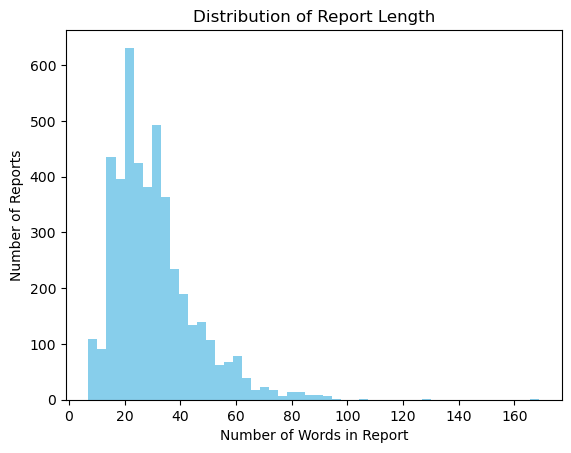

In [9]:
merged_df['number_of_words'] = merged_df['report'].apply(lambda text: len(str(text).split()))
merged_df['number_of_words'] = merged_df['number_of_words'].astype(int)

print("length of report:")
print(merged_df['number_of_words'].describe())

import matplotlib.pyplot as plt
plt.hist(merged_df['number_of_words'], bins=50, color='skyblue')
plt.xlabel('Number of Words in Report')
plt.ylabel('Number of Reports')
plt.title('Distribution of Report Length')
plt.show()

Since a single UID may correspond to multiple images, randomly assigning individual images to the train and test sets could result in images from the same person appearing in both sets. This would compromise the validity of the evaluation. Therefore, we first randomly split the UIDs and assign all images associated with a given UID to either the training or test set accordingly.

In [10]:
images_report_df = merged_df[['uid', 'image_path', 'report', 'number_of_words'] + label_columns].reset_index(drop=True)
image_folder = '/root/.cache/kagglehub/datasets/raddar/chest-xrays-indiana-university/versions/2/images/images_normalized'
image_filenames = images_report_df.image_path.values

# get distinct uid to split train and test
unique_uids = images_report_df['uid'].unique()
train_uids, test_uids = train_test_split(unique_uids, test_size=0.2, random_state=42)

# split
train_captions = images_report_df[images_report_df['uid'].isin(train_uids)].reset_index(drop=True)
test_captions = images_report_df[images_report_df['uid'].isin(test_uids)].reset_index(drop=True)

print("Train shape:", train_captions.shape)
print("Test shape:", test_captions.shape)
print(f"Unique UIDs in train: {train_captions['uid'].nunique()}, in test: {test_captions['uid'].nunique()}")


Train shape: (3595, 20)
Test shape: (902, 20)
Unique UIDs in train: 1845, in test: 462


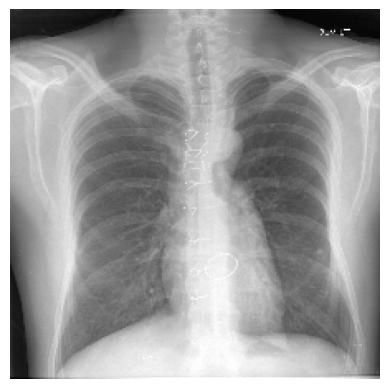

(224, 224, 3)


In [11]:
batch_size = 16
image_size = 224

def preprocess_image(image_path, image_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def display_image(image_np):
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()
image = preprocess_image(f"{path}/images/images_normalized/116_IM-0107-1001.dcm.png",image_size)
display_image(image)
print(image.shape)

# before training

## image preprocessing

In [12]:
num_processors = os.cpu_count()
print(num_processors)

#normalize image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

class ImageTextDataset(Dataset): # construct train dataset
  def __init__(self, image_filenames, text_list, image_size=224, transform = transform):
      self.image_filenames = image_filenames
      self.text_list = text_list  #report
      self.image_size = image_size
      self.transform = transform or transforms.ToTensor()

  def __len__(self):
      return len(self.image_filenames)

  def __getitem__(self, idx):
      image_path = f"{path}/images/images_normalized/{self.image_filenames[idx]}"
      image = preprocess_image(image_path, self.image_size)
      image = self.transform(image)
      text = self.text_list[idx]
      return image, text



32


In [13]:
# For train
train_dataset = ImageTextDataset(train_captions.image_path.values, train_captions.report.values,image_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(train_dataset. __getitem__(0)[0].shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


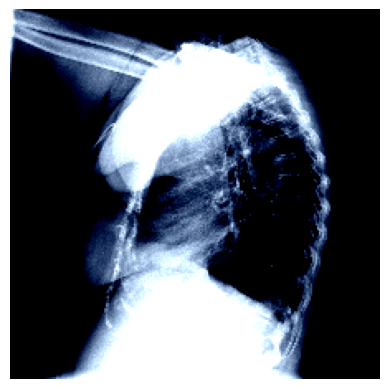

Report: Heart size is mildly enlarged. The pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is a calcified granuloma in the right lung base. There are mild degenerative changes of the spine. There are some chronic increased interstitial markings noted.



In [14]:
images_batch, reports_batch = next(iter(train_dataloader))

image1 = images_batch[0].permute(1, 2, 0).numpy()
report1 = reports_batch[0]

display_image(image1)
print(f"Report: {report1}\n")

# CLIP setting

In [15]:
dropout = 0.1
class ImageProjection(nn.Module):
  def __init__(self, image_embedding_size, shared_embedding_size):
    super(ImageProjection, self).__init__()
    self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
    self.gelu = nn.GELU()
    self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
    self.dropout = nn.Dropout(dropout)
    self.layer_norm = nn.LayerNorm(shared_embedding_size)

  def forward(self, image_embeddings):
    projected_embeddings = self.image_projection(image_embeddings)

    x = self.gelu(projected_embeddings)
    x = self.fc(x)
    x = self.dropout(x)
    x = x + projected_embeddings
    x = self.layer_norm(x)

    return x

class TextProjection(nn.Module):
  def __init__(self, text_embedding_size, shared_embedding_size):
      super(TextProjection, self).__init__()
      self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
      self.gelu = nn.GELU()
      self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
      self.dropout = nn.Dropout(dropout)
      self.layer_norm = nn.LayerNorm(shared_embedding_size)

  def forward(self, text_embeddings):
      projected_embeddings = self.text_projection(text_embeddings)

      x = self.gelu(projected_embeddings)
      x = self.fc(x)
      x = self.dropout(x)
      x = x + projected_embeddings
      x = self.layer_norm(x)

      return x

In [16]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [17]:
dropout = 0.1

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = 2

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
  logits = (text_projection @ image_projection.T) / temperature_value
  if mode=="train":
      images_similarity = image_projection @ image_projection.T
      texts_similarity = text_projection @ text_projection.T
      targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
      texts_loss = cross_entropy(logits, targets, reduction='none')
      images_loss = cross_entropy(logits.T, targets.T, reduction='none')
      loss =  (images_loss + texts_loss) / 2.0
      return loss.mean()
  elif mode=="eval":
      return logits
  else:
      print("Mention mode")
      return None

# Train CLIP

In [18]:
from transformers import AutoTokenizer, AutoModel
shared_embedding_size = 512
# - - - - - - - - - ResNet Model - - - - - - - - -
# Load a pre-trained ResNet model
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
# Remove the classification layer (the last fully connected layer)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
# - - - - - - - - -  Bio_ClinicalBERT  - - - - - - - - -
max_length = 200
text_embedding_size = 768
model_name='emilyalsentzer/Bio_ClinicalBERT'
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)

/home/cpsc452_yc2243/.conda/envs/clip_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cpsc452_yc2243/.conda/envs/clip_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
optimizer = optim.AdamW([
    {"params": resnet_model.parameters(), "lr": 1e-4},
    {"params": text_model.parameters(), "lr": 1e-5},
    {"params": image_projector.parameters(), "lr": 1e-3},
    {"params": text_projector.parameters(), "lr": 1e-3},
    ], weight_decay=1e-3)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=1 , factor=0.8 )
# checkpoint = torch.load("./0502_notransform_10_clip_checkpoint.pth",map_location=torch.device('cpu'))
# resnet_model.load_state_dict(checkpoint['resnet_model'])
# text_model.load_state_dict(checkpoint['text_model'])
# image_projector.load_state_dict(checkpoint['image_projector'])
# text_projector.load_state_dict(checkpoint['text_projector'])
# - - - - - - - - -  Training loop  - - - - - - - - -
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    resnet_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0

    for batch_idx, (images, texts) in enumerate(train_dataloader):
        optimizer.zero_grad()
        # Text
        inputs = text_tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :]
        text_projection = text_projector(text_embeddings)

        # get image embedding
        images = images.to(device)
        image_embeddings = resnet_model(images)
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)
        image_projection = image_projector(image_embeddings)

        # - - - -  Compute Loss  - - - -
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")

    # - - - - Loss each epoch
    lr_scheduler.step(total_loss)
    end_time = time.time()
    elapsed_time = end_time - start_time
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds")

 - - - - - - - - - - - Epoch: 1  - - - - - - - - - - - - 
Epoch [1/10], Batch [0/225], Loss: 0.1322
Epoch [1/10], Batch [200/225], Loss: 0.1317
Epoch [1/10], Average Loss: 2.1026   Time Taken:  204.5936930179596  seconds
 - - - - - - - - - - - Epoch: 2  - - - - - - - - - - - - 
Epoch [2/10], Batch [0/225], Loss: 0.1550
Epoch [2/10], Batch [200/225], Loss: 0.1199
Epoch [2/10], Average Loss: 1.9205   Time Taken:  203.81010031700134  seconds
 - - - - - - - - - - - Epoch: 3  - - - - - - - - - - - - 
Epoch [3/10], Batch [0/225], Loss: 0.1167
Epoch [3/10], Batch [200/225], Loss: 0.1088
Epoch [3/10], Average Loss: 1.7358   Time Taken:  204.46704936027527  seconds
 - - - - - - - - - - - Epoch: 4  - - - - - - - - - - - - 
Epoch [4/10], Batch [0/225], Loss: 0.0818
Epoch [4/10], Batch [200/225], Loss: 0.0988
Epoch [4/10], Average Loss: 1.5960   Time Taken:  202.81729865074158  seconds
 - - - - - - - - - - - Epoch: 5  - - - - - - - - - - - - 
Epoch [5/10], Batch [0/225], Loss: 0.0778
Epoch [5/10],

In [20]:
torch.save({
    'epoch': epoch,
    'resnet_model': resnet_model.state_dict(),
    'text_model': text_model.state_dict(),
    'image_projector': image_projector.state_dict(),
    'text_projector': text_projector.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': lr_scheduler.state_dict(),
}, "./0502_notransform_20_clip_checkpoint.pth")

# multi-label training

In [20]:
from transformers import AutoTokenizer, AutoModel
shared_embedding_size = 512
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
max_length = 200
text_embedding_size = 768
model_name='emilyalsentzer/Bio_ClinicalBERT'
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)

#checkpoint = torch.load("./0502_20_clip_checkpoint.pth",map_location=torch.device('cpu'))
checkpoint = torch.load("./0502_20_clip_checkpoint.pth")
# checkpoint = torch.load("./0502_notransform_10_clip_checkpoint.pth")
resnet_model.load_state_dict(checkpoint['resnet_model'])
text_model.load_state_dict(checkpoint['text_model'])
image_projector.load_state_dict(checkpoint['image_projector'])
text_projector.load_state_dict(checkpoint['text_projector'])

class ImageMultiLabelDataset(Dataset):
    def __init__(self, image_filenames, text_list, label_matrix, image_size=224, transform=transform):
        self.image_filenames = image_filenames
        self.text_list = text_list
        self.label_matrix = label_matrix
        self.image_size = image_size
        self.transform = transform or transforms.ToTensor()
        
    def __len__(self):
      return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = f"{path}/images/images_normalized/{self.image_filenames[idx]}"
        image = preprocess_image(image_path, self.image_size)
        image = self.transform(image)
        labels = self.label_matrix[idx]
        text = self.text_list[idx]
        return image, text, torch.tensor(labels, dtype=torch.float32), image_path


train_dataset_multi = ImageMultiLabelDataset(
    image_filenames=train_captions.image_path.values,
    text_list = train_captions.report.values,
    label_matrix=train_captions[label_columns].values,
    image_size=image_size
)
train_dataloader_multi = DataLoader(train_dataset_multi, batch_size=batch_size, shuffle=True)

num_labels = len(label_columns)  # 16

# FC
classifier = nn.Linear(shared_embedding_size*2, num_labels)
classifier = classifier.to(device)
criterion = nn.BCEWithLogitsLoss()

# freeze CLIP
for param in resnet_model.parameters():
    param.requires_grad = False
for param in image_projector.parameters():
    param.requires_grad = False
for param in text_model.parameters():
    param.requires_grad = False
for param in text_projector.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

/home/cpsc452_yc2243/.conda/envs/clip_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cpsc452_yc2243/.conda/envs/clip_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
num_epochs = 15
for epoch in range(num_epochs):
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )

    classifier.train()

    total_loss = 0.0

    for batch_idx, (images,  texts, labels, image_paths) in enumerate(train_dataloader_multi):
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)  #(batch_size, 16)


        with torch.no_grad():
            image_embeddings = resnet_model(images)
            image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)
            img_proj = image_projector(image_embeddings)
        with torch.no_grad():
            encoded = text_tokenizer(texts, padding=True, truncation=True,
                                     max_length=200, return_tensors="pt").to(device)
            text_output = text_model(**encoded).last_hidden_state[:, 0, :]
            text_proj = text_projector(text_output)

        joint_feature = torch.cat([img_proj, text_proj], dim=1) 

        logits = classifier(joint_feature)  
        loss = criterion(logits, labels.float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader_multi)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    avg_loss = total_loss / len(train_dataloader_multi)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds")

 - - - - - - - - - - - Epoch: 1  - - - - - - - - - - - - 
Epoch [1/15], Batch [0/225], Loss: 0.0434
Epoch [1/15], Batch [200/225], Loss: 0.0093
Epoch [1/15], Average Loss: 0.1461   Time Taken:  149.40011143684387  seconds
 - - - - - - - - - - - Epoch: 2  - - - - - - - - - - - - 
Epoch [2/15], Batch [0/225], Loss: 0.0062
Epoch [2/15], Batch [200/225], Loss: 0.0078
Epoch [2/15], Average Loss: 0.1246   Time Taken:  149.36956453323364  seconds
 - - - - - - - - - - - Epoch: 3  - - - - - - - - - - - - 
Epoch [3/15], Batch [0/225], Loss: 0.0079
Epoch [3/15], Batch [200/225], Loss: 0.0077
Epoch [3/15], Average Loss: 0.1229   Time Taken:  149.3799340724945  seconds
 - - - - - - - - - - - Epoch: 4  - - - - - - - - - - - - 
Epoch [4/15], Batch [0/225], Loss: 0.0109
Epoch [4/15], Batch [200/225], Loss: 0.0077
Epoch [4/15], Average Loss: 0.1215   Time Taken:  149.38216733932495  seconds
 - - - - - - - - - - - Epoch: 5  - - - - - - - - - - - - 
Epoch [5/15], Batch [0/225], Loss: 0.0046
Epoch [5/15],

In [29]:
test_dataset = ImageMultiLabelDataset(
    image_filenames=test_captions.image_path.values,
    text_list = test_captions.report.values,
    label_matrix=test_captions[label_columns].values,
    image_size=image_size
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

from sklearn.metrics import f1_score, hamming_loss, average_precision_score, label_ranking_average_precision_score

classifier = nn.Linear(shared_embedding_size*2, num_labels).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

checkpoint = torch.load("0503_classifier_sharedebb_checkpoint_epoch30.pth", map_location=device)
classifier.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def multilabel_accuracy(preds, labels, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * labels).sum(dim=1)
    union = ((preds + labels) >= 1).float().sum(dim=1)
    acc = (intersection / (union + 1e-8))
    return acc.mean().item()

def evaluate_on_test(resnet_model, image_projector, classifier, test_dataloader, device, threshold=0.5):
    resnet_model.eval()
    image_projector.eval()
    classifier.eval()

    all_probs = []
    all_labels = []
    all_paths = []

    with torch.no_grad():
        for images, text, labels, image_paths in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            image_embeddings = resnet_model(images)
            image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)
            img_proj = image_projector(image_embeddings)
            encoded = text_tokenizer(text, padding=True, truncation=True,
                                     max_length=200, return_tensors="pt").to(device)
            text_output = text_model(**encoded).last_hidden_state[:, 0, :]  # CLS token
            text_proj = text_projector(text_output)
            joint_feature = torch.cat([img_proj, text_proj], dim=1) 

            logits = classifier(joint_feature)
            probs = torch.sigmoid(logits)

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
            all_paths.extend(image_paths)  

    # Concatenate all batches
    y_scores = torch.cat(all_probs, dim=0).numpy()
    y_true = torch.cat(all_labels, dim=0).numpy()
    y_pred = (y_scores > threshold).astype(int)

    # Calculate metrics
    example_acc = multilabel_accuracy(torch.tensor(y_scores), torch.tensor(y_true), threshold=threshold)
    hamming = hamming_loss(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    map_score = average_precision_score(y_true, y_scores, average='macro')
    lrap = label_ranking_average_precision_score(y_true, y_scores)

    print(f"Test Example-based Accuracy (Jaccard): {example_acc:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"Mean Average Precision (mAP): {map_score:.4f}")
    print(f"Label Ranking Average Precision (LRAP): {lrap:.4f}")

    all_probs = torch.cat(all_probs, dim=0).numpy()  
    all_labels = torch.cat(all_labels, dim=0).numpy()
    df = pd.DataFrame(all_probs, columns=[f"pred_{l}" for l in label_columns])
    for i, label in enumerate(label_columns):
        df[f"true_{label}"] = all_labels[:, i]
    df["image_path"] = all_paths
    df.to_csv("0503_ori_1_test_predictions_with_probs.csv", index=False)
    

    return {
        "example_accuracy": example_acc,
        "hamming_loss": hamming,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "mAP": map_score,
        "LRAP": lrap
    }
metrics = evaluate_on_test(resnet_model, image_projector, classifier, test_dataloader, device)
metrics

Test Example-based Accuracy (Jaccard): 0.5602
Hamming Loss: 0.0446
F1 Score (Macro): 0.1252
F1 Score (Micro): 0.6224
Mean Average Precision (mAP): 0.2911
Label Ranking Average Precision (LRAP): 0.7809


{'example_accuracy': 0.5602365136146545,
 'hamming_loss': 0.04455376940133038,
 'f1_macro': 0.12523541263787683,
 'f1_micro': 0.6224310041103934,
 'mAP': np.float64(0.2911016033385547),
 'LRAP': np.float64(0.780927478994275)}

In [28]:
save_path = f"0503_classifier_sharedebb_checkpoint_epoch30.pth"
torch.save({
    'epoch': epoch,
    'model_state_dict': classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, save_path)
print(f"Model saved to {save_path}")

Model saved to 0503_classifier_sharedebb_checkpoint_epoch30.pth


In [53]:
import pandas as pd

df = pd.read_csv("0502_ori_1_test_predictions_with_probs.csv")

label_names = [col.replace("true_", "") for col in df.columns if col.startswith("true_")]

def get_top_pred_label(row):
    pred_probs = {label: row[f"pred_{label}"] for label in label_names}
    top_label = max(pred_probs, key=pred_probs.get)
    return top_label

df["top_pred_label"] = df.apply(get_top_pred_label, axis=1)

df_top_correct = df[df.apply(lambda row: row[f"true_{row['top_pred_label']}"] == 1, axis=1)]
df_top_correct.to_csv("0502_top_correct.csv")
print(f"{len(df_top_correct)} / {len(df)} samples have top-predicted label in true labels.")

521 / 902 samples have top-predicted label in true labels.


In [54]:
'''
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        """
        gamma: focusing parameter
        alpha: class weight for positive samples (can be scalar or tensor of shape [num_labels])
        """
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce_loss = nn.BCELoss(reduction='none')

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        bce = self.bce_loss(probs, targets)

        pt = torch.where(targets == 1, probs, 1 - probs)
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        loss = alpha_t * (1 - pt) ** self.gamma * bce

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
criterion = FocalLoss(gamma=2.0, alpha=0.25, reduction='mean')  

num_epochs = 30
for epoch in range(num_epochs):
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )

    classifier.train()

    total_loss = 0.0

    for batch_idx, (images, labels, image_paths) in enumerate(train_dataloader_multi):
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)  #(batch_size, 16)


        with torch.no_grad():
            image_embeddings = resnet_model(images)
            image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)
            image_projection = image_projector(image_embeddings)


        logits = classifier(image_projection)  # output (batch_size, 16)

        loss = criterion(logits, labels.float())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader_multi)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    avg_loss = total_loss / len(train_dataloader_multi)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds")
'''

'\nclass FocalLoss(nn.Module):\n    def __init__(self, gamma=2.0, alpha=0.25, reduction=\'mean\'):\n        """\n        gamma: focusing parameter\n        alpha: class weight for positive samples (can be scalar or tensor of shape [num_labels])\n        """\n        super().__init__()\n        self.gamma = gamma\n        self.alpha = alpha\n        self.reduction = reduction\n        self.bce_loss = nn.BCELoss(reduction=\'none\')\n\n    def forward(self, logits, targets):\n        probs = torch.sigmoid(logits)\n        bce = self.bce_loss(probs, targets)\n\n        pt = torch.where(targets == 1, probs, 1 - probs)\n        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)\n        loss = alpha_t * (1 - pt) ** self.gamma * bce\n\n        if self.reduction == \'mean\':\n            return loss.mean()\n        elif self.reduction == \'sum\':\n            return loss.sum()\n        else:\n            return loss\ncriterion = FocalLoss(gamma=2.0, alpha=0.25, reduction=\'mean\')

In [59]:
save_path = f"0502_focal_classifier_checkpoint_epoch{epoch+1}.pth"
torch.save({
    'epoch': epoch,
    'model_state_dict': classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, save_path)
print(f"Model saved to {save_path}")

Model saved to 0502_focal_classifier_checkpoint_epoch11.pth


# Multi label decoder

In [37]:
'''
class MLDAdapterBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MLDAdapterBlock, self).__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, text_embeddings, image_embeddings):
        # text_embeddings: (batch, num_labels, dim)
        # image_embeddings: (batch, 1, dim) or (batch, num_patches, dim)

        attn_output, _ = self.cross_attn(query=text_embeddings,
                                         key=image_embeddings,
                                         value=image_embeddings)
        x = self.norm(attn_output + text_embeddings)
        x = self.dropout(x)


        logits = self.fc(x).squeeze(-1)  # (batch, num_labels)
        return logits
def get_text_features(labels, tokenizer, text_model, text_projector, device):
    prompts = [f"This is a chest X-ray showing {label}." for label in labels]
    encoded = text_tokenizer(prompts, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**encoded)
        text_emb = outputs.last_hidden_state[:, 0, :]
        text_proj = text_projector(text_emb)
        text_proj = F.normalize(text_proj, dim=-1)
    return text_proj
text_features = get_text_features(label_columns, text_tokenizer, text_model, text_projector, device)
mld_decoder = MLDAdapterBlock(embed_dim=shared_embedding_size, num_heads=8).to(device)
optimizer = torch.optim.Adam(mld_decoder.parameters(), lr=1e-4)
mld_decoder.train()
for batch_idx, (images, labels, image_paths) in enumerate(train_dataloader_multi):
    optimizer.zero_grad()

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        image_embeddings = resnet_model(images)
        image_embeddings = image_embeddings.view(images.size(0), -1)
        image_proj = image_projector(image_embeddings)  # (B, dim)

    image_proj = image_proj.unsqueeze(1)  # (B, 1, dim) for cross-attn
    text_proj_batch = text_features[:images.size(0)]  # (B, num_labels, dim)

    logits = mld_decoder(text_proj_batch, image_proj)  # (B, num_labels)
    loss = criterion(logits, labels.float())

    loss.backward()
    optimizer.step()
'''

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


AssertionError: For unbatched (2-D) `query`, expected `key` and `value` to be 2-D but found 3-D and 3-D tensors respectively

# zero-shot prediction

In [77]:
from transformers import AutoTokenizer, AutoModel
shared_embedding_size = 512
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
max_length = 200
text_embedding_size = 768
model_name='emilyalsentzer/Bio_ClinicalBERT'
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)

checkpoint = torch.load("./0502_20_clip_checkpoint.pth")
resnet_model.load_state_dict(checkpoint['resnet_model'])
text_model.load_state_dict(checkpoint['text_model'])
image_projector.load_state_dict(checkpoint['image_projector'])
text_projector.load_state_dict(checkpoint['text_projector'])

/home/cpsc452_yc2243/.conda/envs/clip_env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cpsc452_yc2243/.conda/envs/clip_env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [78]:
class ImageMultiLabelDataset(Dataset): # construct test dataset
  def __init__(self, image_filenames, label_matrix, image_size=224, transform=transform):
      self.image_filenames = image_filenames
      self.label_matrix = label_matrix  # (N, num_labels)
      self.image_size = image_size
      self.transform = transform or transforms.ToTensor()

  def __len__(self):
      return len(self.image_filenames)

  def __getitem__(self, idx):
      image_path = f"{path}/images/images_normalized/{self.image_filenames[idx]}"
      image = preprocess_image(image_path, self.image_size)
      image = self.transform(image)
      labels = self.label_matrix[idx]  # one-hot vector
      return image, torch.tensor(labels, dtype=torch.float32), image_path

test_dataset = ImageMultiLabelDataset(
    image_filenames=test_captions.image_path.values,
    label_matrix=test_captions[label_columns].values,
    image_size=image_size
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def get_text_features(labels, tokenizer, text_model, text_projector, device):
    prompts = [f"This is a chest X-ray showing {label}." for label in labels]
    encoded = text_tokenizer(prompts, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**encoded)
        text_emb = outputs.last_hidden_state[:, 0, :]
        text_proj = text_projector(text_emb)
        text_proj = F.normalize(text_proj, dim=-1)
    return text_proj

[no FC]one label predict

In [69]:
import pandas as pd
from collections import Counter
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_zero_shot_top1_soft(dataloader, labels, tokenizer, text_model, text_projector,
                                 resnet_model, image_projector, device="cuda"):
    text_features = get_text_features(labels, tokenizer, text_model, text_projector, device)
    correct = 0
    total = 0

    label_correct_counter = Counter()
    label_total_counter = Counter()

    results = []
    resnet_model.eval()
    image_projector.eval()
    text_projector.eval()
    text_model.eval()

    for images, label_vectors, image_paths in tqdm(dataloader):
        images = images.to(device)

        with torch.no_grad():
            image_embeddings = resnet_model(images).view(images.size(0), -1)
            image_proj = image_projector(image_embeddings)
            image_proj = F.normalize(image_proj, dim=-1)

            sims = image_proj @ text_features.T
            top1_preds = sims.argmax(dim=1).cpu().numpy()

            label_vectors = label_vectors.cpu().numpy()
            true_label_sets = [set(np.where(row == 1)[0]) for row in label_vectors]

            for pred_idx, true_set, img_path in zip(top1_preds, true_label_sets, image_paths):
                total += 1
                pred_label = labels[pred_idx]
                true_label_names = [labels[i] for i in true_set]

                for label in true_set:
                    label_total_counter[label] += 1

                is_correct = int(pred_idx in true_set)
                if is_correct:
                    correct += 1
                    label_correct_counter[pred_idx] += 1

                results.append({
                    "image_path": img_path,
                    "pred_label": pred_label,
                    "true_labels": true_label_names,
                    "correct": is_correct
                })

    label_correct_named = {labels[i]: label_correct_counter[i] for i in label_correct_counter}
    top1_soft_accuracy = correct / total
    print(f"\nTop-1 Soft Accuracy: {top1_soft_accuracy:.4f}")
    print("\nCorrect predictions per label (Top-1 match):")
    for label, count in label_correct_named.items():
        print(f"  {label:25}: {count}")
    result_df = pd.DataFrame(results)
    return top1_soft_accuracy, label_correct_named, result_df


In [70]:
top1_soft_acc, correct_per_label, result_df = evaluate_zero_shot_top1_soft(
    test_dataloader,
    labels=label_columns,
    tokenizer=text_tokenizer, text_model=text_model, text_projector=text_projector,
    resnet_model=resnet_model, image_projector=image_projector,
    device=device
)

print(result_df.head())
result_df.to_csv("top1_soft_predictions.csv", index=False)


100%|██████████| 57/57 [00:36<00:00,  1.56it/s]


Top-1 Soft Accuracy: 0.4667

Correct predictions per label (Top-1 match):
  Normal                   : 356
  Granuloma                : 36
  Pleural Effusion         : 3
  Hernia                   : 6
  Cardiomegaly             : 18
  Pulmonary Edema          : 1
  Fibrosis                 : 1
                                          image_path pred_label  \
0  /home/cpsc452_yc2243/.cache/kagglehub/datasets...     Hernia   
1  /home/cpsc452_yc2243/.cache/kagglehub/datasets...     Hernia   
2  /home/cpsc452_yc2243/.cache/kagglehub/datasets...     Normal   
3  /home/cpsc452_yc2243/.cache/kagglehub/datasets...     Normal   
4  /home/cpsc452_yc2243/.cache/kagglehub/datasets...  Granuloma   

                                    true_labels  correct  
0  [Pleural Effusion, Consolidation, Emphysema]        0  
1  [Pleural Effusion, Consolidation, Emphysema]        0  
2                                      [Normal]        1  
3                                      [Normal]        1  
4     

[no FC] multi-label predict

In [72]:
from sklearn.metrics import f1_score, hamming_loss, average_precision_score, label_ranking_average_precision_score
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm

def evaluate_zero_shot_multilabel(dataloader, labels, tokenizer, text_model, text_projector,
                                   resnet_model, image_projector, threshold=0.5, device="cuda"):
    text_features = get_text_features(labels, tokenizer, text_model, text_projector, device)
    resnet_model.eval()
    image_projector.eval()
    text_projector.eval()
    text_model.eval()

    all_probs = []
    all_trues = []
    image_paths = []

    for images, label_vectors, paths in tqdm(dataloader):
        images = images.to(device)
        with torch.no_grad():
            img_feat = resnet_model(images).view(images.size(0), -1)
            img_proj = image_projector(img_feat)
            img_proj = F.normalize(img_proj, dim=-1)
            sims = img_proj @ text_features.T
            probs = torch.sigmoid(sims).cpu().numpy()  # (batch, num_labels)

        all_probs.append(probs)
        all_trues.append(label_vectors.numpy())
        image_paths.extend(paths)

    y_true = np.vstack(all_trues)     # shape (N, C)
    y_pred_prob = np.vstack(all_probs)  # shape (N, C)
    y_pred_bin = (y_pred_prob > threshold).astype(int)

    # Compute metrics
    hamming = hamming_loss(y_true, y_pred_bin)
    f1_micro = f1_score(y_true, y_pred_bin, average="micro")
    f1_macro = f1_score(y_true, y_pred_bin, average="macro")
    mAP = average_precision_score(y_true, y_pred_prob, average="macro")
    lrap = label_ranking_average_precision_score(y_true, y_pred_prob)

    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 (micro): {f1_micro:.4f}")
    print(f"F1 (macro): {f1_macro:.4f}")
    print(f"mAP: {mAP:.4f}")
    print(f"LRAP: {lrap:.4f}")

    df = pd.DataFrame({
        "image_path": image_paths,
        **{f"true_{label}": y_true[:, i] for i, label in enumerate(labels)},
        **{f"pred_{label}": y_pred_prob[:, i] for i, label in enumerate(labels)},
    })

    return {
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "hamming": hamming,
        "mAP": mAP,
        "LRAP": lrap,
        "df": df
    }
evaluate_zero_shot_multilabel(test_dataloader,
    labels=label_columns,
    tokenizer=text_tokenizer, text_model=text_model, text_projector=text_projector,
    resnet_model=resnet_model, image_projector=image_projector,
    device=device
)

100%|██████████| 57/57 [00:36<00:00,  1.55it/s]

Hamming Loss: 0.3449
F1 (micro): 0.2002
F1 (macro): 0.1605
mAP: 0.1349
LRAP: 0.5761


{'f1_micro': 0.20022497187851518,
 'f1_macro': 0.16053133829249447,
 'hamming': 0.34485864745011086,
 'mAP': np.float64(0.1349252910480383),
 'LRAP': np.float64(0.576062669315163),
 'df':                                             image_path  true_Cardiomegaly  \
 0    /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 1    /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 2    /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 3    /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 4    /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 ..                                                 ...                ...   
 897  /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 898  /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 899  /home/cpsc452_yc2243/.cache/kagglehub/datasets...                0.0   
 900  /home/cpsc452_yc2243/.cache

Grad_CAM

In [ ]:
list(resnet_model.children())

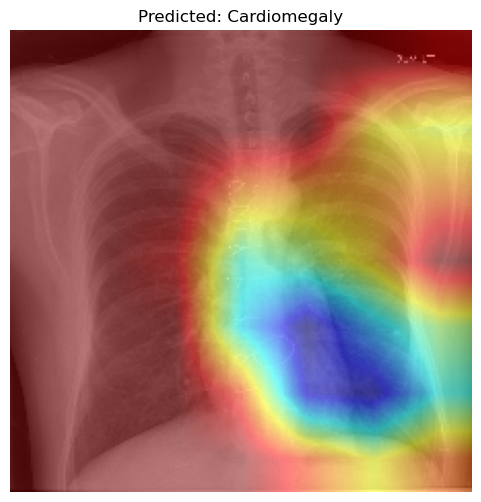

0

In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def predict_image_label_with_gradcam(image_path, preprocess_image, transform,
                                     resnet_model, image_projector, labels,
                                     tokenizer, text_model, text_projector,
                                     target_label_idx, device="cuda"):
    text_features = get_text_features(labels, tokenizer, text_model, text_projector, device)
    # Step 1: Hook setup
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Choose target layer
    # target_layer = resnet_model.layer4[-1]
    target_layer = resnet_model[7][-1] # Last block of last layer
    hook_f = target_layer.register_forward_hook(forward_hook)
    hook_b = target_layer.register_full_backward_hook(backward_hook)

    # Preprocess image
    img_np = preprocess_image(image_path, image_size)
    # img_tensor = transform(img_np).unsqueeze(0).to(device)
    img_tensor = transforms.ToTensor()(img_np).unsqueeze(0).to(device)

    # Forward pass
    resnet_model.eval()
    image_projector.eval()
    text_projector.eval()
    text_model.eval()
    with torch.enable_grad():
        img_tensor.requires_grad_()
        img_feat_map = resnet_model(img_tensor)               # (1, 2048, 7, 7)
        pooled_feat = img_feat_map.view(1, -1)                # Flatten for projection
        img_proj = image_projector(pooled_feat)
        img_proj = F.normalize(img_proj, dim=-1)

        sim = (img_proj @ text_features.T)  # (1, num_labels)
        pred_label = sim.argmax(dim=1).item()

        # Optionally: choose your own target label index
        target_idx = target_label_idx if target_label_idx is not None else pred_label

        sim[0, target_idx].backward()  # Backprop for specific class

    # Step 2: Get gradients and activations
    grads_val = gradients[0].cpu().data.numpy()[0]           # shape: (C, H, W)
    acts_val = activations[0].cpu().data.numpy()[0]          # shape: (C, H, W)

    # Step 3: Compute Grad-CAM
    weights = np.mean(grads_val, axis=(1, 2))  # average gradient over spatial dims
    cam = np.zeros(acts_val.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts_val[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    cam -= cam.min()
    cam /= cam.max()

    # Step 4: Overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = 0.5 * heatmap + 0.5 * img_np
    save_path = f"./gradcam_{labels[pred_label]}.jpg"
    cv2.imwrite(save_path, overlay.astype(np.uint8))

    # Cleanup
    hook_f.remove()
    hook_b.remove()

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Predicted: {labels[pred_label]}")
    plt.axis('off')
    plt.show()

    return pred_label
predict_image_label_with_gradcam(
    image_path=f"{path}/images/images_normalized/116_IM-0107-1001.dcm.png",
    preprocess_image=preprocess_image,
    transform=transform,
    resnet_model=resnet_model,
    image_projector=image_projector,
    labels = label_columns,
    tokenizer = text_tokenizer,
    text_model = text_model,
    text_projector = text_projector,
    target_label_idx=None,  # auto use predicted label
    device=device
)


# gradcam(after adding fc adapter)

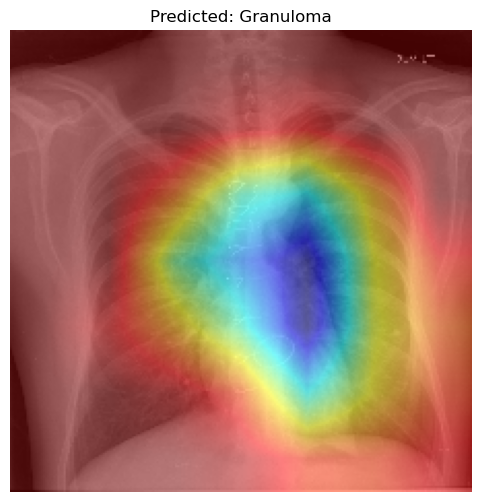

(14,
 array([0.06308306, 0.13950026, 0.02052738, 0.04163474, 0.01357745,
        0.05319809, 0.01695362, 0.01465063, 0.00135589, 0.03165675,
        0.05543225, 0.00599847, 0.00082208, 0.01807596, 0.2521145 ,
        0.21846986], dtype=float32))

In [94]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

def predict_image_label_with_gradcam_fc(
    image_path, preprocess_image, transform,
    resnet_model, image_projector, classifier,
    label_names,
    target_label_idx=None,
    image_size=224,
    device="cuda"
):
    # Step 1: Hook setup
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Set target layer 
    target_layer = resnet_model[7][-1] 
    hook_f = target_layer.register_forward_hook(forward_hook)
    hook_b = target_layer.register_full_backward_hook(backward_hook)

    # Step 2: Preprocess image
    img_np = preprocess_image(image_path, image_size)  # numpy array
    img_tensor = transform(img_np).unsqueeze(0).to(device)  # (1, 3, H, W)
    #img_tensor = transforms.ToTensor()(img_np).unsqueeze(0).to(device)


    # Step 3: Forward + Backward
    resnet_model.eval()
    image_projector.eval()
    classifier.eval()

    with torch.enable_grad():
        img_tensor.requires_grad_()
        # img_feat_map = resnet_model(img_tensor)  # (1, 2048, 7, 7)
        # # print(img_feat_map.shape)
        # pooled_feat = img_feat_map.view(1, -1)   # Flatten to (1, 2048)
        # img_proj = image_projector(pooled_feat)  # (1, shared_embedding_size)

        image_embeddings = resnet_model(img_tensor)
        image_embeddings = image_embeddings.view(image_embeddings.size(0), -1)
        img_proj = image_projector(image_embeddings)

        logits = classifier(img_proj)            # (1, num_labels)
        probs = torch.sigmoid(logits)            # (0, 1)

        # Get prediction or use target index
        pred_label = torch.argmax(probs, dim=1).item()
        target_idx = target_label_idx if target_label_idx is not None else pred_label

        logits[0, target_idx].backward()  # backprop for specific class

    # Step 4: Compute Grad-CAM
    grads_val = gradients[0].cpu().data.numpy()[0]  # (C, H, W)
    acts_val = activations[0].cpu().data.numpy()[0]  # (C, H, W)

    weights = np.mean(grads_val, axis=(1, 2))  # (C,)
    cam = np.zeros(acts_val.shape[1:], dtype=np.float32)  # (H, W)

    for i, w in enumerate(weights):
        cam += w * acts_val[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    # cam = 1.0 - cam

    # Step 5: Overlay heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = 0.5 * heatmap + 0.5 * img_np
    save_path = f"./gradcam_fc_{label_names[target_idx]}.jpg"
    cv2.imwrite(save_path, overlay.astype(np.uint8))

    # Cleanup
    hook_f.remove()
    hook_b.remove()

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"Predicted: {label_names[pred_label]}")
    plt.axis('off')
    plt.show()

    return pred_label, probs[0].detach().cpu().numpy()

predict_image_label_with_gradcam_fc(
    image_path=f"{path}/images/images_normalized/116_IM-0107-1001.dcm.png",
    preprocess_image=preprocess_image,
    transform=transform,
    resnet_model=resnet_model,
    image_projector=image_projector,
    classifier = classifier,
    label_names = label_columns,
    target_label_idx=None,  # auto use predicted label
    device=device
)